<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Evaluación</h4>
</center>

In [46]:
# Importación librerias

# !pip install awswrangler
# !pip install boto3
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Definición fechas

date_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

# Versión modelo
data_version = '1'
grouped_columns = ["product_id"]
grouped_cols_name = "product"

# Parametros backtest
dataset_frequency='M'
quantiles=["mean", "p50"]

Fecha inicio historia 2017-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


In [4]:
# Conexiones AWS

account_id=boto3.client('sts').get_caller_identity().get('Account')
session = boto3.Session() 
forecast = session.client(service_name='forecast')
region = forecast.meta.region_name
forecastquery = session.client(service_name='forecastquery')
role = f'arn:aws:iam::{account_id}:role/ForecastRole'

In [5]:
# Buckets de datos

# Data
target_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

# Outputs
backtest_export_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/output/'

In [6]:
# Formar ARNs

dataset_group_arn=f'arn:aws:forecast:us-east-1:{account_id}:dataset-group/modelo_{data_version}_{grouped_cols_name}'
# Se busca de la notebook 3
codigo_predictor = '01HZG49YKVPFHRYBPFZPG3KTYK'
automl_predictor_arn = f'arn:aws:forecast:us-east-1:{account_id}:predictor/modelo_{data_version}_predictor_{codigo_predictor}'

In [7]:
# Verificar comunicación con Amazon Forecast
assert forecast.list_predictors()

### Backtest export job

In [8]:
# Nombre del projecto y dataset group
backtest_export_job_name = f"modelo_{data_version}_predictor_export"
backtest_export_job_name

'modelo_1_predictor_export'

El siguiente codigo funciona para crear backtest export job y guardar los archivos en la ruta especificada. La siguiente salida arroja error porque este primer modelo fue ejecutado integramente desde la UI de forecast

In [9]:
# response = forecast.create_predictor_backtest_export_job(
#     PredictorBacktestExportJobName=backtest_export_job_name,
#     PredictorArn=automl_predictor_arn,
#     Destination={
#         'S3Config': {
#             'Path': backtest_export_path,
#             'RoleArn': role
#         }
#     },
#     Format='CSV'
# )
# backtest_export_job_arn = response['PredictorBacktestExportJobArn']

El siguiente código permite seguir el status del export job. Como la celda de arriba da error, también da error.

In [10]:
# print(f"Waiting for Backtest export job with ARN {backtest_export_job_arn} to be completed. \nCurrent Status:")
# forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn=
#                 backtest_export_job_arn)['Status']

### Evaluate

In [11]:
df_forecasts=wr.s3.read_csv(backtest_export_path + 'forecasted-values/')
df_forecasts['periodo']=pd.to_datetime(df_forecasts['timestamp'], format='%Y-%m-%dT%H:%M:%SZ').dt.date
df_forecasts['product_id']=df_forecasts['item_id']
df_forecasts = df_forecasts.drop(columns = {"item_id", "target_value", "backtestwindow_start_time", "backtestwindow_end_time", "timestamp"})
for q in quantiles:
    df_forecasts[q] = df_forecasts[q].astype(float)
df_forecasts.head()
df_forecasts = df_forecasts[["periodo"] + grouped_columns + quantiles]
df_forecasts['product_id']=df_forecasts['product_id'].astype(str)
df_forecasts['periodo']=pd.to_datetime(df_forecasts['periodo'])
df_forecasts.head(5)

,periodo,product_id,mean,p50
0,2019-11-01,20569,10.033112,10.681765
1,2019-12-01,20569,9.023050,8.007465
2,2019-11-01,21248,0.096925,0.128645
3,2019-12-01,21248,0.061881,0.039678
4,2019-11-01,20219,21.932106,20.743980


In [12]:
df_forecasts.dtypes

periodo       datetime64[ns]
product_id            object
mean                 float64
p50                  float64
dtype: object

- Backtest timing

In [13]:
print('Start backtest: ', df_forecasts['periodo'].astype(str).min())
print('End backtest: ', df_forecasts['periodo'].astype(str).max())

Start backtest:  2019-11-01
End backtest:  2019-12-01


In [14]:
date_min_forecast = df_forecasts['periodo'].astype(str).min()
date_min_forecast = pd.to_datetime(date_min_forecast)

- Backtest items check

In [15]:
len(df_forecasts.product_id.unique())

771

- Read historic sales data

In [16]:
# Leer el archivo CSV sin encabezado
df_ventas_mensuales = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header=None, index_col=False)
column_names = ["periodo"] + grouped_columns + ["venta"]
df_ventas_mensuales.columns = column_names
df_ventas_mensuales['periodo'] = pd.to_datetime(df_ventas_mensuales['periodo'])
df_ventas_mensuales['product_id']=df_ventas_mensuales['product_id'].astype(str)
df_ventas_mensuales.head(5)

,periodo,product_id,venta
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [17]:
df_ventas_mensuales.dtypes

periodo       datetime64[ns]
product_id            object
venta                float64
dtype: object

In [18]:
len(df_ventas_mensuales.product_id.unique())

780

- Productos sin forecast

In [19]:
total_productos = df_ventas_mensuales.product_id.drop_duplicates().to_list()
productos_forecast = df_forecasts.product_id.drop_duplicates().to_list()
set1 = set(total_productos)
set2 = set(productos_forecast)
# Encontrar elementos que están en set1 pero no en set2
elementos_en_set1_no_en_set2 = set1 - set2
# Encontrar elementos que están en set2 pero no en set1
elementos_en_set2_no_en_set1 = set2 - set1
# Unir los resultados
elementos_no_comunes = elementos_en_set1_no_en_set2.union(elementos_en_set2_no_en_set1)
list(elementos_no_comunes)

['20210',
 '20127',
 '21214',
 '20995',
 '21087',
 '20962',
 '20686',
 '20975',
 '20703']

In [20]:
df_ventas_mensuales[df_ventas_mensuales.product_id.isin(list(elementos_no_comunes))].periodo.min()
# Solo tienen historia desde septiembre, no alcanza cantidad de historia requerida por AWS FORECAST.
# Requiere horizonte de prediccion (2 meses) * 2 = 4 meses de historia anteriores a periodo de backtest

Timestamp('2019-09-01 00:00:00')

In [21]:
print('Start historical sales: ', df_ventas_mensuales['periodo'].min())
print('End historical sales: ', df_ventas_mensuales['periodo'].max())

Start historical sales:  2017-01-01 00:00:00
End historical sales:  2019-12-01 00:00:00


- Unión info histórica y forecast

In [22]:
df_forecasts.dtypes

periodo       datetime64[ns]
product_id            object
mean                 float64
p50                  float64
dtype: object

In [23]:
df_ventas_mensuales.dtypes

periodo       datetime64[ns]
product_id            object
venta                float64
dtype: object

In [24]:
# Para los meses en los que coexiste venta real con forecast se realiza un merge outer
df_forecasts_historic=pd.merge(df_forecasts[df_forecasts['periodo']>=date_min_forecast], df_ventas_mensuales[df_ventas_mensuales['periodo']>=date_min_forecast], how='outer', on=['periodo'] + grouped_columns)
df_forecasts_historic=df_forecasts_historic[['periodo'] + grouped_columns + ['venta'] + quantiles]
# Para los meses históricos, previos a la proyección de forecast, se realiza un concat
df_forecasts_historic = pd.concat([df_ventas_mensuales[df_ventas_mensuales['periodo']<date_min_forecast], df_forecasts_historic])
df_forecasts_historic.head(5)

,periodo,product_id,venta,mean,p50
0,2017-01-01,20001,934.77222,NaN,NaN
1,2017-01-01,20002,550.15707,NaN,NaN
2,2017-01-01,20003,1063.45835,NaN,NaN
3,2017-01-01,20004,555.91614,NaN,NaN
4,2017-01-01,20005,494.27011,NaN,NaN


In [25]:
# Ok correcta concatenación: sacamos productos que no generan forecast ya que hacen que los números no coincidan y eso es correcto
df_forecasts_historic_check = df_forecasts_historic[~df_forecasts_historic.product_id.isin(list(elementos_no_comunes))]
df_ventas_mensuales_check = df_ventas_mensuales[~df_ventas_mensuales.product_id.isin(list(elementos_no_comunes))]
len(df_forecasts_historic_check) == len(df_forecasts[df_forecasts['periodo']>=date_min_forecast]) + len(df_ventas_mensuales_check[df_ventas_mensuales_check['periodo']<date_min_forecast])

True

In [26]:
df_forecasts_historic[['venta'] + quantiles]=df_forecasts_historic[['venta'] + quantiles].astype(float)
df_forecasts_historic['month']=pd.to_datetime(df_forecasts_historic['periodo']).dt.to_period('M')
df_forecasts_historic=df_forecasts_historic[['periodo', 'month'] + grouped_columns + ['venta'] + quantiles]

In [27]:
df_forecasts_historic.head(1)

,periodo,month,product_id,venta,mean,p50
0,2017-01-01,2017-01,20001,934.77222,NaN,NaN


- Agregamos fuentes adicionales

In [28]:
df_productos = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_products.csv")
df_productos.columns = ["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]
df_productos["product_id"] = df_productos["product_id"].astype(str)
df_productos.head(5)

,product_id,cat1,cat2,cat3,brand,sku_size
0,20180,HC,ROPA LAVADO,Liquido,LIMPIEX,450
1,20332,HC,ROPA LAVADO,Liquido,LIMPIEX,120
2,20222,HC,ROPA LAVADO,Liquido,LIMPIEX,450
3,20288,HC,ROPA LAVADO,Liquido,LIMPIEX,900
4,20082,HC,ROPA MANCHAS,Ladrillo,LIMPIEX,200


In [29]:
df_forecasts_historic = pd.merge(df_forecasts_historic, df_productos, how = "left", on = "product_id")
df_forecasts_historic.head(5)

,periodo,month,product_id,venta,mean,p50,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,2017-01,20001,934.77222,NaN,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,2017-01,20002,550.15707,NaN,NaN,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.0
2,2017-01-01,2017-01,20003,1063.45835,NaN,NaN,FOODS,ADEREZOS,Mayonesa,NATURA,475.0
3,2017-01-01,2017-01,20004,555.91614,NaN,NaN,FOODS,ADEREZOS,Mayonesa,NATURA,240.0
4,2017-01-01,2017-01,20005,494.27011,NaN,NaN,FOODS,ADEREZOS,Mayonesa,NATURA,120.0


- Definición funciones de medición de error

In [30]:
def text_format(val):
    color = 'salmon' if val > 0.3 else 'green'
    return 'color: %s' % color

In [31]:
def format_zero(val):
    color = 'black' if type(val) == str else ('salmon' if val < 0 else 'green')
    return 'color: %s' % color

In [32]:
def forecasts_error_total(df_forecasts, quantile):
    df_forecasts=df_forecasts[df_forecasts['periodo']>=date_min_forecast]
    df_forecasts_grouped = df_forecasts.groupby(['month'] + grouped_columns)[['venta', quantile]].sum().reset_index()
    df_forecasts_grouped['error_absoluto']=abs(df_forecasts_grouped['venta']-df_forecasts_grouped[quantile])
    df_forecasts_grouped =(df_forecasts_grouped.groupby(['month'])['error_absoluto'].sum()
                           /df_forecasts_grouped.groupby(['month'])['venta'].sum()).reset_index(name='error')
    df_forecasts_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df_forecasts_grouped

In [33]:
def forecasts_error_grouped(df_forecasts, feature, time_column, target_value, quantile):
    df_forecasts=df_forecasts[df_forecasts['periodo']>=date_min_forecast]
    df_forecasts_grouped = df_forecasts.groupby([time_column] + grouped_columns + [feature])[[target_value, quantile]].sum().reset_index()
    df_forecasts_grouped['error_absoluto']=abs(df_forecasts_grouped[target_value]-df_forecasts_grouped[quantile])
    df_forecasts_grouped =(df_forecasts_grouped.groupby([time_column, feature])['error_absoluto'].sum()
                           /df_forecasts_grouped.groupby([time_column, feature])[target_value].sum()).reset_index(name='error')
    df_forecasts_grouped=df_forecasts_grouped.pivot(index=[feature], columns=[time_column], values='error')
    df_forecasts_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_forecasts_grouped['mean_error']=df_forecasts_grouped.mean(axis=1, skipna=True)
    return df_forecasts_grouped

In [34]:
def forecasts_error_item(df_forecasts, features, time_column, quantile, target_value):
    df_forecasts=df_forecasts[df_forecasts['periodo']>=date_min_forecast]
    df_forecasts_grouped = df_forecasts.groupby([time_column, 'product_id']+features)[[target_value, quantile]].sum().reset_index()
    df_forecasts_grouped['error_absoluto']=abs(df_forecasts_grouped[target_value]-df_forecasts_grouped[quantile])
    df_forecasts_grouped =(df_forecasts_grouped.groupby([time_column, 'product_id'] + features)['error_absoluto'].sum()
                           /df_forecasts_grouped.groupby([time_column, 'product_id']+ features)[target_value].sum()).reset_index(name='error')
    df_forecasts_grouped=df_forecasts_grouped.pivot(index=['product_id'] + features, columns=[time_column], values='error')
    df_forecasts_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_forecasts_grouped['mean_error']=df_forecasts_grouped.mean(axis=1, skipna=True)
    return df_forecasts_grouped

- Evaluación total general

In [35]:
forecasts_error_total(df_forecasts_historic, "mean").style.applymap(lambda x: text_format(x), ['error'])

,month,error
0,2019-11,0.253956
1,2019-12,0.312290


In [36]:
forecasts_error_total(df_forecasts_historic, "p50").style.applymap(lambda x: text_format(x), ['error'])

,month,error
0,2019-11,0.255210
1,2019-12,0.301612


- Evaluación por categorias

In [37]:
forecasts_error_grouped(df_forecasts_historic, feature='cat1', time_column='month', target_value='venta', quantile='mean').style.applymap(lambda x: text_format(x))

month,2019-11,2019-12,mean_error
cat1,,,
FOODS,0.281055,0.356441,0.318748
HC,0.253565,0.285998,0.269781
PC,0.233188,0.352079,0.292634
REF,3.040537,4.009565,3.525051


In [38]:
forecasts_error_grouped(df_forecasts_historic, feature='cat2', time_column='month', target_value='venta', quantile='mean').style.applymap(lambda x: text_format(x))

month,2019-11,2019-12,mean_error
cat2,,,
ADEREZOS,0.279925,0.312189,0.296057
CABELLO,0.264034,0.434456,0.349245
DENTAL,0.640803,0.282596,0.461699
DEOS,0.183762,0.231084,0.207423
HOGAR,0.225231,0.340845,0.283038
OTROS,0.299703,0.639960,0.469832
PIEL1,0.325453,0.299075,0.312264
PIEL2,0.130644,0.224389,0.177517
PROFESIONAL,0.284855,0.277530,0.281193


- Evaluación por items principales

In [39]:
items_relevantes = ["20001", "20002", "20003", "20004", "20005", "20006", "20007", "20008", "20009", "20010"]

In [40]:
# forecast_mean
forecasts_error_item(df_forecasts_historic[df_forecasts_historic.product_id.isin(items_relevantes)], features=[], time_column='month', target_value='venta', quantile='mean').reset_index().rename_axis(None, axis=1).set_index("product_id").style.applymap(text_format)

,2019-11,2019-12,mean_error
product_id,,,
20001,0.100477,0.004941,0.052709
20002,0.056230,0.200370,0.128300
20003,0.189475,0.057133,0.123304
20004,0.262445,0.246001,0.254223
20005,0.168281,0.064781,0.116531
20006,0.278835,0.171467,0.225151
20007,0.182077,0.012937,0.097507
20008,0.123801,1.244712,0.684256
20009,0.263405,0.090203,0.176804


In [41]:
df_forecasts_historic[df_forecasts_historic.product_id == "20008"].sort_values(by = "periodo").tail(6)

,periodo,month,product_id,venta,mean,p50,cat1,cat2,cat3,brand,sku_size
17709,2019-07-01,2019-07,20008,524.04994,NaN,NaN,HC,VAJILLA,Opaco,LIMPIEX,750.0
18465,2019-08-01,2019-08,20008,233.00983,NaN,NaN,HC,VAJILLA,Opaco,LIMPIEX,750.0
19236,2019-09-01,2019-09,20008,330.56343,NaN,NaN,HC,VAJILLA,Opaco,LIMPIEX,750.0
20016,2019-10-01,2019-10,20008,452.77197,NaN,NaN,HC,VAJILLA,Opaco,LIMPIEX,750.0
22005,2019-11-01,2019-11,20008,396.49833,445.585100,448.853695,HC,VAJILLA,Opaco,LIMPIEX,750.0
22006,2019-12-01,2019-12,20008,195.36854,438.546136,445.551985,HC,VAJILLA,Opaco,LIMPIEX,750.0


- Graficos

In [59]:
def graficar_producto(df, product_id):
    # Filtrar los datos para un producto específico
    filtered_data = df[df["product_id"] == product_id]
    filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])

    # Crear una figura y ejes
    plt.figure(figsize=(10, 6))

    # Graficar la serie de tiempo de ventas
    sns.lineplot(data=filtered_data, x="periodo", y="venta", marker="x", label="Venta")
    # Graficar la serie de tiempo de medias
    sns.lineplot(data=filtered_data, x="periodo", y="mean", marker="o", label="Forecast")

    # Añadir título y etiquetas
    plt.title("Serie de tiempo de ventas y medias para el producto {}".format(product_id))
    plt.xlabel("Mes")
    plt.ylabel("Venta / Forecast")

    # Mostrar la leyenda
    plt.legend(title="Variable", loc="upper left")

    # Mostrar el gráfico
    return plt.show()
    

In [71]:
def graficar_categorias(df, categoria, categoria_filtrada):
    # Filtrar los datos para un producto específico
    filtered_data = df.groupby(["periodo", categoria]).agg({"mean":"sum", "venta":"sum"}).reset_index()
    filtered_data["mean"] = np.where( filtered_data["periodo"] < date_min_forecast, np.nan,  filtered_data["mean"])
    filtered_data = filtered_data[filtered_data[categoria] == categoria_filtrada]
    filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])

    # Crear una figura y ejes
    plt.figure(figsize=(10, 6))

    # Graficar la serie de tiempo de ventas
    sns.lineplot(data=filtered_data, x="periodo", y="venta", marker="x", label="Venta")
    # Graficar la serie de tiempo de medias
    sns.lineplot(data=filtered_data, x="periodo", y="mean", marker="o", label="Forecast")

    # Añadir título y etiquetas
    plt.title(f"Serie de tiempo de ventas y medias para {categoria} filtrado para {categoria_filtrada}")
    plt.xlabel("Mes")
    plt.ylabel("Venta / Forecast")

    # Mostrar la leyenda
    plt.legend(title="Variable", loc="upper left")

    # Mostrar el gráfico
    return plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_1964\3446482089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])


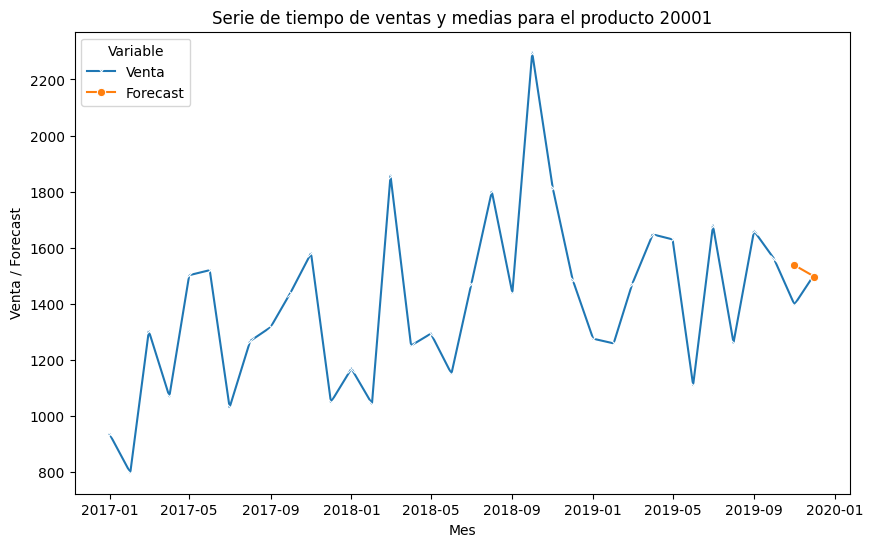

In [60]:
graficar_producto(df_forecasts_historic, product_id = "20001")

C:\Users\usuario\AppData\Local\Temp\ipykernel_1964\3446482089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])


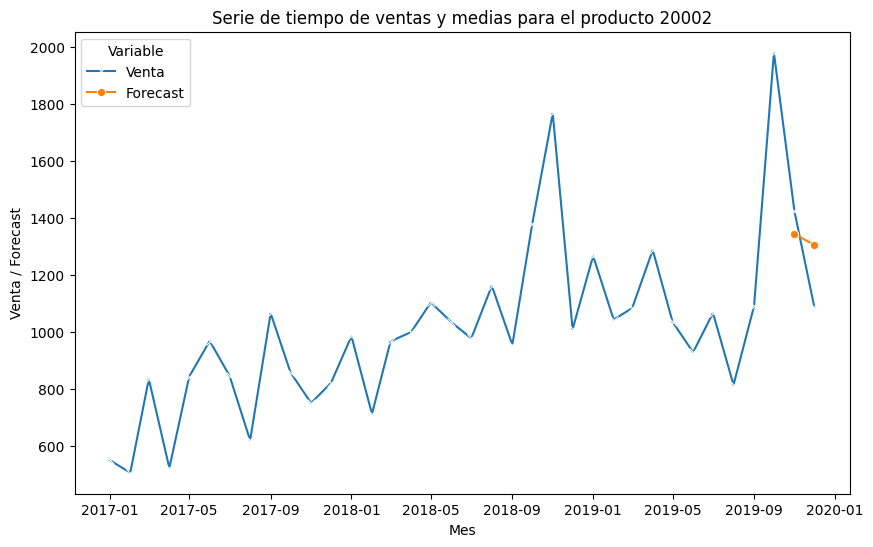

In [61]:
graficar_producto(df_forecasts_historic, product_id = "20002")

C:\Users\usuario\AppData\Local\Temp\ipykernel_1964\3446482089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])


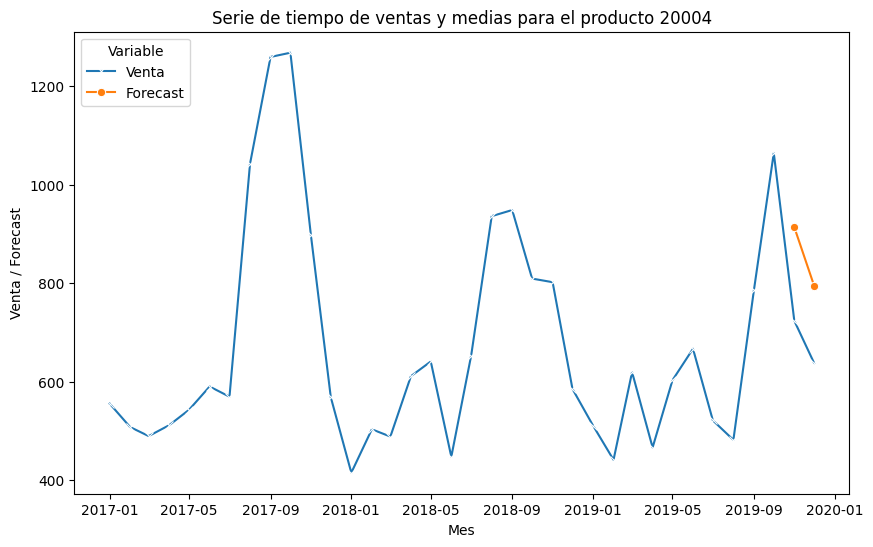

In [62]:
graficar_producto(df_forecasts_historic, product_id = "20004")

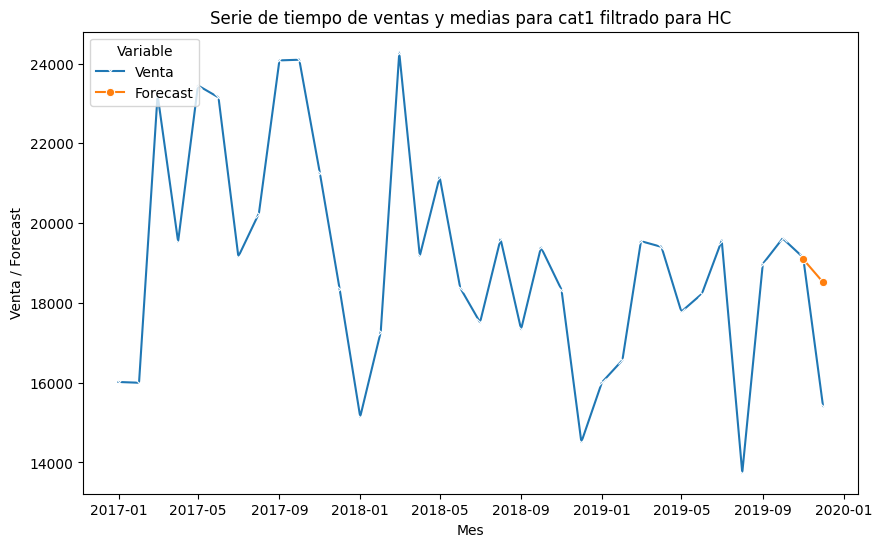

In [72]:
graficar_categorias(df_forecasts_historic, categoria = "cat1", categoria_filtrada = "HC")

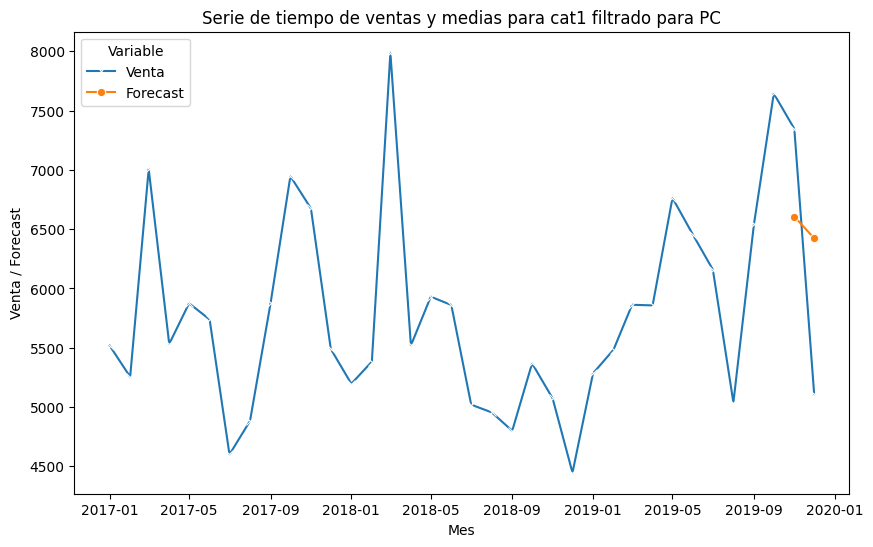

In [73]:
graficar_categorias(df_forecasts_historic, categoria = "cat1", categoria_filtrada = "PC")

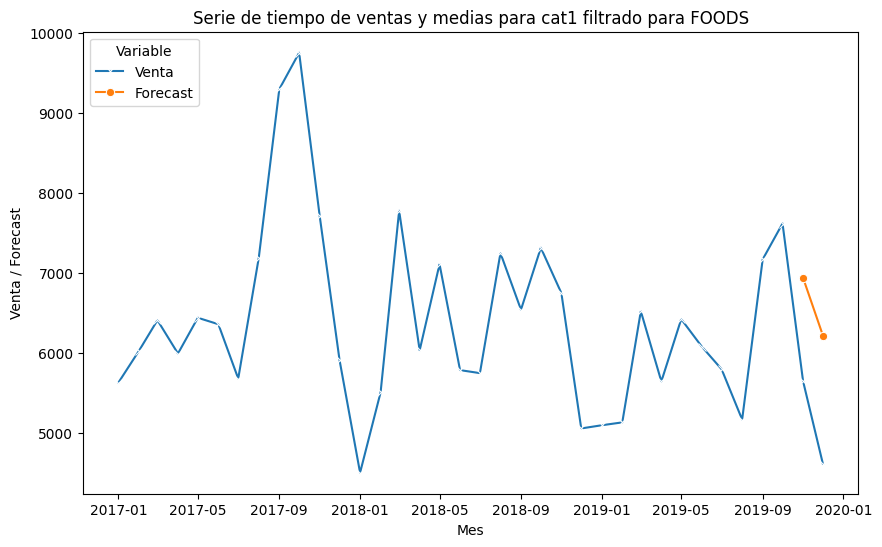

In [75]:
graficar_categorias(df_forecasts_historic, categoria = "cat1", categoria_filtrada = "FOODS")

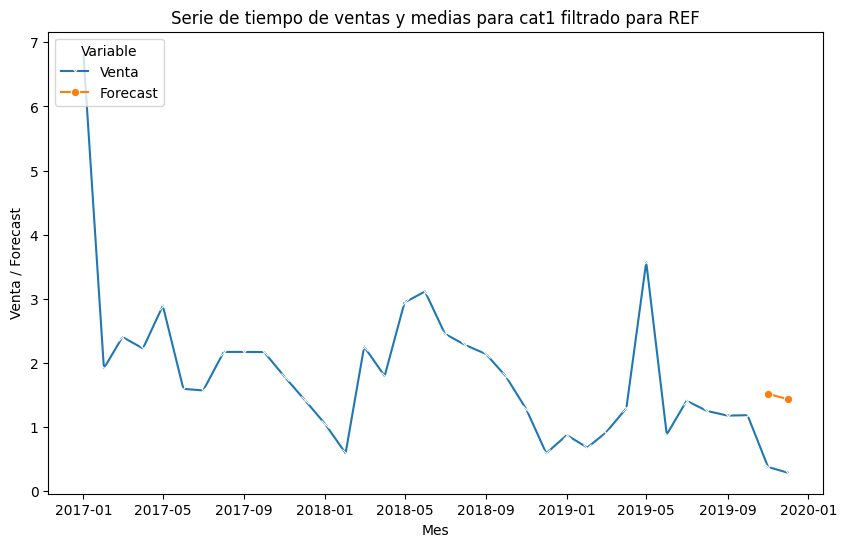

In [74]:
graficar_categorias(df_forecasts_historic, categoria = "cat1", categoria_filtrada = "REF")